# Analyze song features such as syllable entropy & entropy variance

In [6]:
# Import packages
from database.load import ProjectLoader
import matplotlib.pyplot as plt
from deafening.plot import plot_bar_comparison
import seaborn as sns
import numpy as np
import pandas as pd
from util import save
from util.draw import remove_right_top
import warnings
warnings.filterwarnings('ignore')

## Plot across days

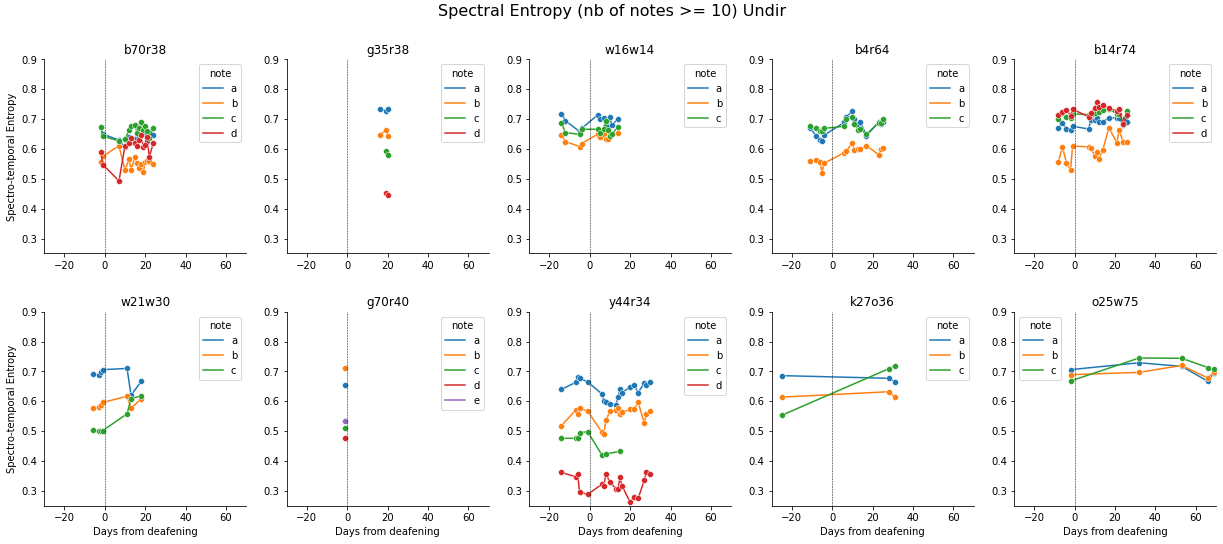

In [7]:
# Plot the results across days
# Parameters
nb_row = 3
nb_col = 4
save_fig = False
fig_ext = '.png'
nb_note_crit = 10
fr_crit = 0
feature = 'Spectral Entropy'  
# feature = 'Spectro-temporal Entropy'

# Load song database
# csv_path = ProjectLoader().path / 'EntropySpkCorrNew' / 'ev new_window.csv'

db = ProjectLoader().load_db()
# # SQL statement
df = db.to_dataframe(
    f"SELECT syl.*, song.taskSession, song.taskSessionDeafening, song.taskSessionPostDeafening, song.dph, song.block10days "
    f"FROM syllable syl INNER JOIN song ON syl.songID = song.id WHERE syl.nbNoteUndir >= {nb_note_crit}")
df.set_index('syllableID')

circ_size = 0.5
fig, axes = plt.subplots(2, 5, figsize=(21, 8))
fig.subplots_adjust(hspace=.3, wspace=.2, top=0.9)

fig.get_axes()[0].annotate(f"{feature} (nb of notes >= {nb_note_crit}) Undir", (0.5, 0.97),
                           xycoords='figure fraction',
                           ha='center',
                           fontsize=16)
axes = axes.ravel()

bird_list = df['birdID'].unique()

for bird, ax_ind in zip(bird_list, range(len(bird_list))):

    temp_df = df.loc[df['birdID'] == bird]
    sns.lineplot(x='taskSessionDeafening', y='spectroTemporalEntropyUndir', hue='note',
                 data=temp_df, ci=None, marker='o', mew=circ_size, ax=axes[ax_ind])
    remove_right_top(axes[ax_ind])
    axes[ax_ind].set_title(bird)
    if ax_ind >= 5:
        axes[ax_ind].set_xlabel('Days from deafening')
    else:
        axes[ax_ind].set_xlabel('')

    if (ax_ind == 0) or (ax_ind == 5):
        axes[ax_ind].set_ylabel('Spectro-temporal Entropy')
    else:
        axes[ax_ind].set_ylabel('')

    axes[ax_ind].set_xlim([-30, 70])
    # axes[ax_ind].set_ylim([0, 0.03])
    axes[ax_ind].set_ylim([0.25, 0.9])
    axes[ax_ind].axvline(x=0, color='k', linestyle='dashed', linewidth=0.5)

# Save figure
if save_fig:
    save_path = save.make_dir(ProjectLoader().path / 'Analysis', 'Results')
    save.save_fig(fig, save_path, feature, fig_ext=fig_ext, view_folder=False)
else:
    plt.show()

## Plot significance proportion

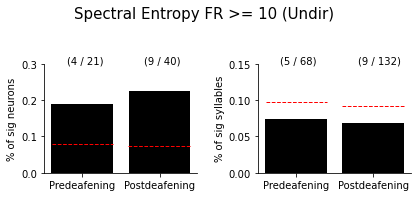

0.032
0.032


In [8]:
nb_note_crit = 10
fr_crit = 10
# csv_path = r'H:\Box\Data\Deafening Project\Analysis\EntropySpkCorrNew\spectral_entropy new_window.csv'
# csv_path = r'H:\Box\Data\Deafening Project\Analysis\EntropySpkCorrNew\spectro_temporal_entropy new_window.csv'
csv_path = r'H:\Box\Data\Deafening Project\Analysis\EntropySpkCorrNew\ev new_window.csv'
df = pd.read_csv(csv_path, index_col='syllableID')
df = df.query(f"nbNoteUndir >= {nb_note_crit} and premotorFRUndir >= {fr_crit}" )

# Get proportion of neurons showing significant correlation per task
title = 'Spectral Entropy'  # {'Spectro-temporal Entropy', 'Spectral Entropy', 'EV'}
total_neurons = {}
sig_neurons = {}
sig_prop = {}

# Plot the results
fig, ax = plt.subplots(figsize=(6, 3))
plt.suptitle(f'{title} FR >= {fr_crit} (Undir) ', y=.9, fontsize=15)
ax = plt.subplot2grid((4, 2), (1, 0), rowspan=3, colspan=1)

# Calculate sig neuronal proportion
df_corr_sig = df.groupby(['clusterID','taskName'])['spkCorrSigUndir'].sum().reset_index()
df_shuffled_sig = df.groupby(['clusterID','taskName'])['shuffledSigPropUndir'].mean().reset_index()
tasks = sorted(set(df['taskName']), reverse=True)
for ind, task in enumerate(tasks):
    sig_array = df_corr_sig[(df_corr_sig['taskName'] == task)]['spkCorrSigUndir']
    shuffled_sig_array = df_shuffled_sig[(df_shuffled_sig['taskName'] == task)]['shuffledSigPropUndir']
    baseline_prop = shuffled_sig_array.mean() + (2*shuffled_sig_array.std())
    total_neurons[task] = len(sig_array)
    sig_neurons[task] = (sig_array >= 1).sum()
    sig_prop[task] = (sig_array >= 1).sum() / len(sig_array)
    ax.bar(ind, sig_prop[task], color='k')
    ax.set_ylabel('% of sig neurons')
    ax.set_ylim([0, 0.3])
    ax.set_xticks([0, 1])
    ax.set_xticklabels(tasks)
    ax.text(ind-0.20, ax.get_ylim()[-1], f'({sig_neurons[task]} / {total_neurons[task]})', c='k')
    # Mark baseline proportion
    if ind == 0:
        ax.axhline(y=baseline_prop,
                   xmin=ind+0.05, xmax=ind+0.45,
                   color='r', ls='--', lw=1)
    else:
        ax.axhline(y=baseline_prop,
                   xmin=ind-0.05, xmax=ind-0.45,
                   color='r', ls='--', lw=1)
    remove_right_top(ax)

# Calculate sig syllables
total_syllables = {}
sig_syllables = {}
sig_prop = {}

ax = plt.subplot2grid((4, 2), (1, 1), rowspan=3, colspan=1)
for ind, task in enumerate(tasks):
    sig_array = df[(df['taskName'] == task)]['spkCorrSigUndir']
    shuffled_sig_array = df[(df['taskName'] == task)]['shuffledSigPropUndir']
    baseline_prop = shuffled_sig_array.mean() + (2*shuffled_sig_array.std())
#     print(baseline_prop)
    total_syllables[task] = len(sig_array)
    sig_syllables[task] = (sig_array >= 1).sum()
    sig_prop[task] = (sig_array >= 1).sum() / len(sig_array)
    ax.bar(ind, sig_prop[task], color='k')
    ax.set_ylabel('% of sig syllables')
    ax.set_ylim([0, 0.15])
    ax.set_xticks([0, 1])
    ax.set_xticklabels(tasks)
    ax.text(ind-0.2, ax.get_ylim()[-1], f'({sig_syllables[task]} / {total_syllables[task]})', c='k')
    # Mark baseline proportion
    if ind == 0:
        ax.axhline(y=baseline_prop,
                   xmin=ind+0.05, xmax=ind+0.45,
                   color='r', ls='--', lw=1)
    else:
        ax.axhline(y=baseline_prop,
                   xmin=ind-0.05, xmax=ind-0.45,
                   color='r', ls='--', lw=1)
    remove_right_top(ax)
    
plt.tight_layout()
plt.show()

# Proportion Z-test
import numpy as np
from statsmodels.stats.proportion import proportions_ztest
count = np.array([2, 14])
nobs = np.array([21, 40])
stat, pval = proportions_ztest(count, nobs)
print('{0:0.3f}'.format(pval))

# Fisher's exact test
from scipy.stats import fisher_exact
oddsratio, pvalue = fisher_exact([[2, 25], [21, 40]])
print('{0:0.3f}'.format(pval))

## Plot significance scatter plot

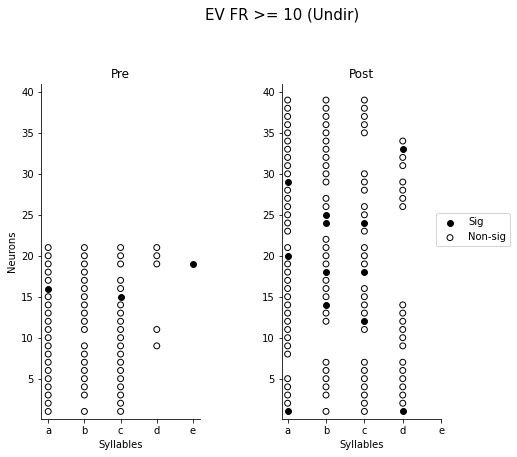

In [9]:
# Map note to numbers
import pandas as pd

feature = 'EV'
nb_note_crit = 10
fr_crit = 10
# csv_path = r'H:\Box\Data\Deafening Project\Analysis\EntropySpkCorr\spectro_temporal_entropy\spectro_temporal_entropy.csv'
# # csv_path = r'H:\Box\Data\Deafening Project\Analysis\EntropySpkCorr\spectral_entropy\spectral_entropy.csv'
csv_path = r'H:\Box\Data\Deafening Project\Analysis\EntropySpkCorr\ev\ev.csv'
df = pd.read_csv(csv_path, index_col='syllableID')
df = df.query(f"nbNoteUndir >= {nb_note_crit} and premotorFRUndir >= {fr_crit}" )

note_dict = {}
for ind, note in enumerate(sorted(df['note'].unique())):
    note_dict[note] = ind+1

# Plot the results
circ_size = 35

fig, ax = plt.subplots(figsize=(8, 7))
plt.suptitle(f'{feature} FR >= {fr_crit} (Undir) ', y=.9, fontsize=15)

for ind, task in enumerate(sorted(df['taskName'].unique(), reverse=True)):
    ax = plt.subplot2grid((5, 5), (1, ind*2), rowspan=4, colspan=2)
    task_df = df[(df['taskName'] == task)]

    for y_loc, cluster in enumerate(task_df['clusterID'].unique()):
        temp_df = task_df[(task_df['clusterID'] == cluster)]
        for note in temp_df['note'].unique():
            corr_sig = temp_df[(temp_df['note'] == note)]['spkCorrSigUndir'].to_numpy(dtype=int)
            if corr_sig:
                ax.scatter(note_dict[note], y_loc+1, s=circ_size, color='k')
            else:
                ax.scatter(note_dict[note], y_loc+1, s=circ_size, facecolors='none', color='k')

    ax.set_xticks(range(1, 6))
    ax.set_xticklabels(sorted(df['note'].unique()))
    ax.set_ylim([0.1, 41])
    if ind == 0:
        ax.set_ylabel('Neurons')
        ax.set_title('Pre')

    if ind == 1:
        ax.set_title('Post')
        ax.legend(['Sig', 'Non-sig'], loc='lower center', bbox_to_anchor=(1.2, 0.5))
        # set spacing to subplots
        fig.tight_layout()
    ax.set_xlabel('Syllables')
    remove_right_top(ax)

plt.show()

- Correlation between # of spikes and song features (e.g., entropy, spectro-temporal entropy, entropy variance, etc)
- Mark syllables where there was a significant correlation (filled circle for significant, emtpy circle for non-significant)

In [10]:
# Load song database
db = ProjectLoader().load_db()
# # SQL statement
df = db.to_dataframe(
    f"SELECT syl.*, song.taskSession, song.taskSessionDeafening, song.taskSessionPostDeafening, song.dph, song.block10days "
    f"FROM syllable syl INNER JOIN song ON syl.songID = song.id WHERE syl.nbNoteUndir >= {nb_note_crit}")
df.set_index('syllableID')

,songID,birdID,taskName,note,nbNoteUndir,nbNoteDir,entropyUndir,entropyDir,spectroTemporalEntropyUndir,spectroTemporalEntropyDir,entropyVarUndir,entropyVarDir,taskSession,taskSessionDeafening,taskSessionPostDeafening,dph,block10days
syllableID,,,,,,,,,,,,,,,,,
5,2,b70r38,Predeafening,a,29,7.0,0.798,NaN,0.674,NaN,0.0130,NaN,19,-2,0,117,0
6,2,b70r38,Predeafening,b,28,6.0,0.583,NaN,0.556,NaN,0.0059,NaN,19,-2,0,117,0
7,2,b70r38,Predeafening,c,28,6.0,0.823,NaN,0.672,NaN,0.0112,NaN,19,-2,0,117,0
8,2,b70r38,Predeafening,d,25,5.0,0.614,NaN,0.591,NaN,0.0215,NaN,19,-2,0,117,0
9,3,b70r38,Predeafening,a,37,29.0,0.772,0.743,0.650,0.665,0.0121,0.0142,20,-1,0,118,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
379,107,o25w75,Postdeafening,b,26,NaN,0.829,NaN,0.678,NaN,0.0106,NaN,66,66,66,239,4
380,107,o25w75,Postdeafening,c,26,NaN,0.864,NaN,0.713,NaN,0.0051,NaN,66,66,66,239,4
381,108,o25w75,Postdeafening,a,20,12.0,0.837,0.809,0.696,0.653,0.0077,0.0111,69,69,69,242,4


In [11]:
df.columns

Index(['syllableID', 'songID', 'birdID', 'taskName', 'note', 'nbNoteUndir',
       'nbNoteDir', 'entropyUndir', 'entropyDir',
       'spectroTemporalEntropyUndir', 'spectroTemporalEntropyDir',
       'entropyVarUndir', 'entropyVarDir', 'taskSession',
       'taskSessionDeafening', 'taskSessionPostDeafening', 'dph',
       'block10days'],
      dtype='object')

## Plot song features across day blocks

In [12]:
# Get pre-deafening baseline
query = f"""SELECT syl.birdID, syl.taskName, song.taskSessionPostDeafening, song.block10days, syl.note, syl.entropy, syl.entropyVar AS ev
            FROM individual_syllable syl INNER JOIN song
            ON song.id = syl.songID WHERE syl.context='U' AND syl.taskName='Predeafening'"""
df_pre = db.to_dataframe(query)

## Number of notes from pre-deafening

In [13]:
import pprint
nb_note_pre = df_pre.groupby(['birdID', 'note'])['note'].count().to_dict()
pprint.pprint(nb_note_pre)

{('b14r74', 'a'): 198,
 ('b14r74', 'b'): 181,
 ('b14r74', 'c'): 180,
 ('b14r74', 'd'): 179,
 ('b4r64', 'a'): 480,
 ('b4r64', 'b'): 480,
 ('b4r64', 'c'): 478,
 ('b70r38', 'a'): 66,
 ('b70r38', 'b'): 62,
 ('b70r38', 'c'): 61,
 ('b70r38', 'd'): 58,
 ('g70r40', 'a'): 39,
 ('g70r40', 'b'): 39,
 ('g70r40', 'c'): 39,
 ('g70r40', 'd'): 37,
 ('g70r40', 'e'): 34,
 ('k27o36', 'a'): 119,
 ('k27o36', 'b'): 112,
 ('k27o36', 'c'): 108,
 ('o25w75', 'a'): 147,
 ('o25w75', 'b'): 146,
 ('o25w75', 'c'): 145,
 ('w16w14', 'a'): 673,
 ('w16w14', 'b'): 447,
 ('w16w14', 'c'): 406,
 ('w21w30', 'a'): 644,
 ('w21w30', 'b'): 626,
 ('w21w30', 'c'): 623,
 ('y44r34', 'a'): 314,
 ('y44r34', 'b'): 309,
 ('y44r34', 'c'): 119,
 ('y44r34', 'd'): 228}


## 50/50% random split of the pre-deafening data into template song and pre-deafening song

In [20]:
def split_df(df_pre):
    """
    Randomly split the pre-song data
    """
    # bird_list = df_pre['birdID'].unique()
    df_baseline = pd.DataFrame()  # will be used for template song for normalizing pre & post song
    df_pre_data = pd.DataFrame() # pre-deafening song to be plotted (block 0)

    for (bird, note), _ in nb_note_pre.items():
        # if bird != 'b14r74':  continue
        df_temp = df_pre.loc[(df_pre['birdID'] == bird) & (df_pre['note'] == note)]
        # 50% split 
        df_temp1 = df_temp.sample(frac=0.5, random_state=1)
        df_temp2 = df_temp.drop(df_temp1.index)
        df_baseline = pd.concat([df_baseline, df_temp1], axis=0)  # used for normalization
        df_pre_data = pd.concat([df_pre_data, df_temp2], axis=0)  # used for data plotting (block 0)
        
    df_baseline = df_baseline.groupby(['birdID', 'note', 'block10days'])['entropy', 'ev'].mean().reset_index() # averaged per bird and syllable 
    df_pre_data = df_pre_data.groupby(['birdID', 'note', 'block10days'])['entropy', 'ev'].mean().reset_index() # averaged per bird and syllable 
    return df_baseline, df_pre_data

df_baseline, df_pre_data = split_df(df_pre)

In [21]:
# Get post-deafening data
db = ProjectLoader().load_db()
query = f"""SELECT syl.birdID, syl.taskName, song.taskSessionPostDeafening, song.block10days, syl.note, syl.entropy, syl.entropyVar AS ev
            FROM individual_syllable syl INNER JOIN song
            ON song.id = syl.songID WHERE syl.context='U' AND syl.taskName='Postdeafening'"""
df_post = db.to_dataframe(query)
df_post_data = df_post.groupby(['birdID', 'note', 'block10days'])['entropy', 'ev'].mean().reset_index()  # get the mean entropy & ev per note per block
df_post_data['nb_notes'] = df_post.groupby(['birdID', 'note', 'block10days'])['note'].count().values  # add number of notes column

In [22]:
df_post_data.head()

,birdID,note,block10days,entropy,ev,nb_notes
0,b14r74,a,1,0.661519,0.018273,291
1,b14r74,a,2,0.682901,0.016744,172
2,b14r74,a,3,0.698318,0.014319,324
3,b14r74,b,1,0.633401,0.004493,272
4,b14r74,b,2,0.618947,0.005085,131


## Concatenate pre & post and normalize by division with pre-deafening baseline

In [86]:
df_all = pd.concat([df_pre_data, df_post_data], axis=0)
birds = df_all['birdID'].unique()
notes = df_all['note'].unique()

def get_norm_df(df_all, df_baseline):
    # Get a new table that has normalized song features
    df_norm = pd.DataFrame()

    for bird in birds:
#         if bird != 'b14r74': continue
        for note in notes:

            df_temp1 = df_all.query(f"birdID == '{bird}' and note == '{note}'") 
            df_temp2 = df_baseline.query(f"birdID == '{bird}' and note == '{note}'")  # baseline
            if not len(df_temp1) or not len(df_temp2): continue
            print(bird, note)
            df_temp1['entropy'] /= df_temp2['entropy'].values
            df_temp1['ev'] /= df_temp2['ev'].values
            df_norm = pd.concat([df_norm, df_temp1], axis=0)  # used for normalization
            
    return df_norm

df_norm = get_norm_df(df_all, df_baseline)

b14r74 a
b14r74 b
b14r74 c
b14r74 d
b4r64 a
b4r64 b
b4r64 c
b70r38 a
b70r38 b
b70r38 c
b70r38 d
g70r40 a
g70r40 b
g70r40 c
g70r40 d
g70r40 e
k27o36 a
k27o36 b
k27o36 c
o25w75 a
o25w75 b
o25w75 c
w16w14 a
w16w14 b
w16w14 c
w21w30 a
w21w30 b
w21w30 c
y44r34 a
y44r34 b
y44r34 c
y44r34 d


## Plot the results across day blocks

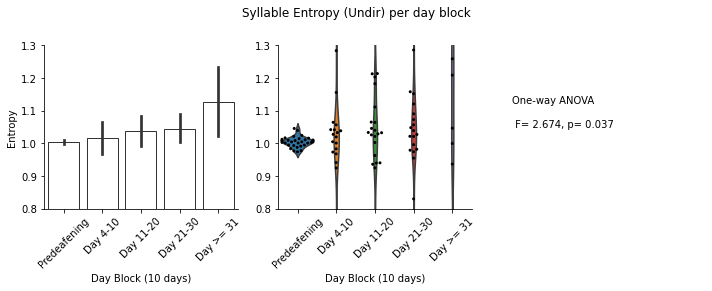

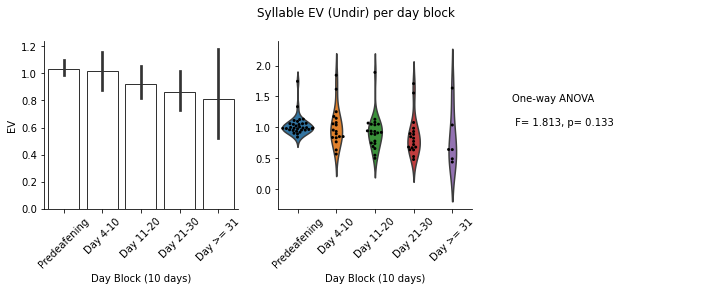

In [105]:
from deafening.plot import plot_bar_comparison, plot_per_day_block

# Entropy
plot_per_day_block(df_norm, ind_var_name='block10days', dep_var_name='entropy',
                   title=f'Syllable Entropy (Undir) per day block',
                   y_label='Entropy',
                   y_lim=[0.8, 1.3],
#                    post_hoc=True,
                   fig_name='Syllable_entropy_across_day_blocks',
                   save_fig=False, fig_ext='.png'
                   )


# EV
plot_per_day_block(df_norm, ind_var_name='block10days', dep_var_name='ev',
                   title=f'Syllable EV (Undir) per day block',
                   y_label='EV',
#                    y_lim=[0.5, 1.5],
#                    post_hoc=True,
                   fig_name='Syllable_ev_across_day_blocks',
                   save_fig=False, fig_ext='.png'
                   )


In [99]:
df_norm.to_csv(outputfile, index=True, header=True)  # save the dataframe to .cvs format

df_norm

,birdID,note,block10days,entropy,ev,nb_notes
0,b14r74,a,0,0.987955,1.006653,NaN
0,b14r74,a,1,1.001076,1.146250,291.0
1,b14r74,a,2,1.033433,1.050358,172.0
2,b14r74,a,3,1.056764,0.898216,324.0
1,b14r74,b,0,1.016028,1.057219,NaN
...,...,...,...,...,...,...
63,y44r34,c,3,1.021179,1.554677,24.0
31,y44r34,d,0,1.009356,1.095532,NaN
64,y44r34,d,1,1.027698,0.633257,176.0
65,y44r34,d,2,0.940601,0.894038,154.0


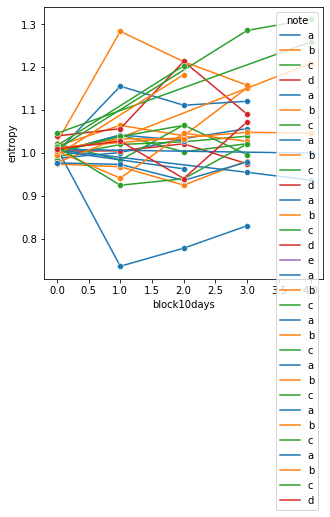

In [108]:
circ_size = 0.5
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
# fig.subplots_adjust(hspace=.3, wspace=.2, top=0.9)

# fig.get_axes()[0].annotate(f"{feature} (nb of notes >= {nb_note_crit}) Undir", (0.5, 0.97),
#                            xycoords='figure fraction',
#                            ha='center',
#                            fontsize=16)
# axes = axes.ravel()
for bird in df_norm['birdID'].unique():
    sns.lineplot(x='block10days', y='entropy', 
                 hue='note',
                 data=df_norm.query(f"birdID == '{bird}'"), ci=None, marker='o', mew=circ_size, ax=ax)